# Linear Regression

Simple Linear Regression is an approach for predicting a response using a single feature, assuming that both variables are linearly related.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score

from matplotlib import ticker
import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')

### Data

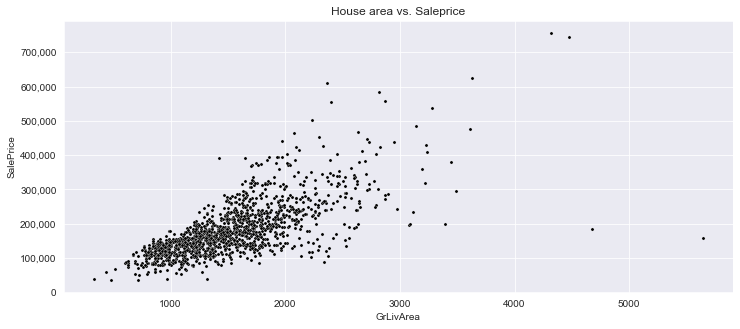

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/alexxvives/Models/main/Data/LinearRegression_data.csv')
x = data['GrLivArea']
y = data['SalePrice']

plt.figure(figsize=(12, 5))
plt.title('House area vs. Saleprice')
ax = sns.scatterplot(x, y, color='k', s=10)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

### Find the line of best fit

Now the task is to find a line that fits best in the above scatter plot so that we can predict the response for any new feature values.<br>

The line of best fit is defined as: $y = \beta_0 + \beta_1 x$

Our goal is to determine $\beta_0$ and $\beta_1$ such that the cost function $J(\beta_0, \beta_1) = \frac{1}{2n}\sum\limits^n_{i=1} (y_i - \hat{y}_i)^2$ is minimized.<br>

I will cover three methods in this notebook:
* Gradient Descent
* Normal Equation
* Singular Value Decomposition

#### Gradient Descent

Gradient descent is an iterative optimization algorithm to find the minimum of a function.

First, both $\beta_0$ and $\beta_1$ are randomly initialized and used to obtain an initial prediction vector $\hat{y}$ through the equation $\hat{y} = \beta_0 + \beta_1x$. Then, we plug our predictions in our cost function to obtain the cost associated with those beta values. Finally, the beta parameters are updated using the following equation: $\beta = \beta - \alpha \frac{\partial J}{\partial \beta}$, where $\frac{\partial J}{\partial \beta}$ represents the derivative of our cost function with respect to each parameter beta (its gradient). Which points towards the steepest descending direction.<br>

This process is repeated until the cost function stops decreasing.

In [4]:
alpha = 0.01 #Step size
iterations = 200 #No. of iterations
n = len(y) #No. of data points
np.random.seed(101) #Set the seed
beta = np.random.rand(2) #Pick some random values to start with

def gradient_descent(x, y, beta, iterations, alpha):
    x = (x - x.mean()) / x.std() #Standardize the feature variable 
    x = np.c_[np.ones(x.shape[0]), x] #Add a column of 1s for the intercept
    
    past_costs = []
    past_betas = [beta]
    for i in range(iterations):
        prediction = np.dot(x, beta)
        error = prediction - y
        cost = 1/(2*n) * np.dot(error.T, error)
        past_costs.append(cost)
        beta = beta - (alpha * (2/n) * np.dot(x.T, error))
        past_betas.append(beta)
        
    return past_betas, past_costs

past_betas, past_costs = gradient_descent(x, y, beta, iterations, alpha)
GD_betas = past_betas[-1].copy() # Save the optimal betas

print("Gradient Descent -> beta_0 = {}, beta_1 = {}".format(round(GD_betas[0]), round(GD_betas[1])))

Gradient Descent -> beta_0 = 177739, beta_1 = 55302


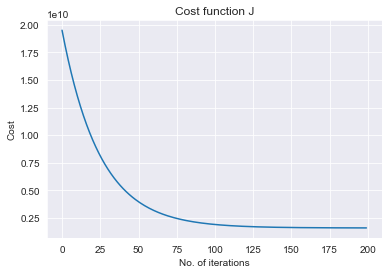

In [5]:
#Plot the cost function...
plt.title('Cost function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(past_costs)
plt.show()

Great! We found the optimal coefficients for the best fit line. The problem is that those coefficients are for our standardized feature. Let's obtain the coefficients that align to our actual feature.

Carrying out the regression with the standardized regressors, we obtain the fitted regression line: $\hat{y} = \beta_0 + \sum\limits_{i=1}^k \beta_i z_i$, where $z_i$ represents our standardized feature x and k=1 (only one feature). <br>
Let's rearrange it:<br>
$\hat{y} = \beta_0 + \sum\limits_{i=1}^k \beta_i (\frac{x_i-\bar{x_i}}{\sigma_i}) = (\beta_0 - \sum\limits_{i=1}^k \beta_i (\frac{\bar{x_i}}{\sigma_i})) + \sum\limits_{i=1}^k (\frac{\beta_i}{\sigma_i})x_i$

Now it is clear that the intercept for the regression is given by $\beta_0 - \sum\limits_{i=1}^k \beta_i (\frac{\bar{x_i}}{\sigma_i})$ and the regression coefficient of the ith predictor is given by $\frac{\beta_i}{\sigma_i}$.

Let's take a look at the progression towards the best line of fit of Gradient Descent, and its result.

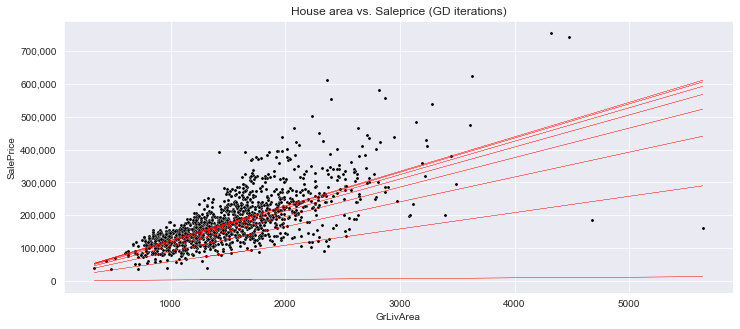

In [68]:
plt.figure(figsize=(12, 5))
plt.title('House area vs. Saleprice (GD iterations)')
ax = sns.scatterplot(x, y, color='k', s=10)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

for idx in list(range(1, len(past_betas), 30)) + [len(past_betas)-1]:
    GD_betas[0] = past_betas[idx][0] -  past_betas[idx][1] * x.mean() / x.std()
    GD_betas[1] =  past_betas[idx][1] / x.std()
    plt.plot(x, GD_betas[0] + GD_betas[1]*x, color='r', linewidth=0.25)

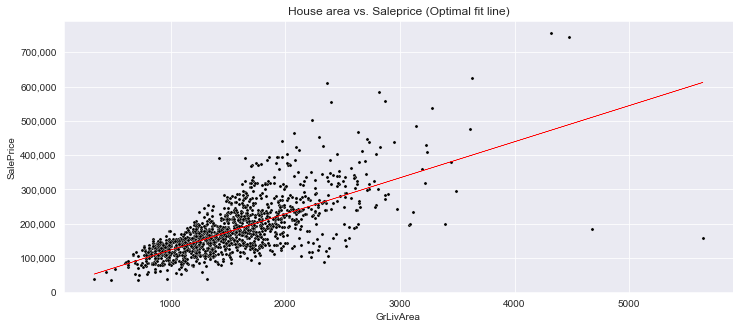

In [69]:
plt.figure(figsize=(12,5))
plt.title('House area vs. Saleprice (Optimal fit line)')
ax = sns.scatterplot(x, y, color='k', s=10)
plt.plot(x, GD_betas[0] + GD_betas[1]*x, color='r', linewidth=0.5)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

#### Normal Equation

Now, let's find the optimal beta values using the Normal Equation.<br>

The best fit line equation in matrix form is $Y=X\theta$, where we are interested in solving for $\theta$.<br>
The easiest way of doing that would be to simply take the inverse of our features gathered in X and solving for $\theta$, like so: $X^{-1}Y= \theta$. But this is only possible if X is a square matrix, which is rarely the case. <br>

Instead, we can multiply by $X^T$ on both sides and then take the inverse of $X^TX$, which will always be square: $X^TY= X^TX\theta \rightarrow (X^TX)^{-1}X^TY= \theta$.

This is the Normal Equation!

In [49]:
X = np.c_[np.ones(x.shape[0]), x] #Add a column of 1s for the intercept

NE_betas = np.linalg.inv(X.T @ X) @ X.T @ y # Compute the normal equation

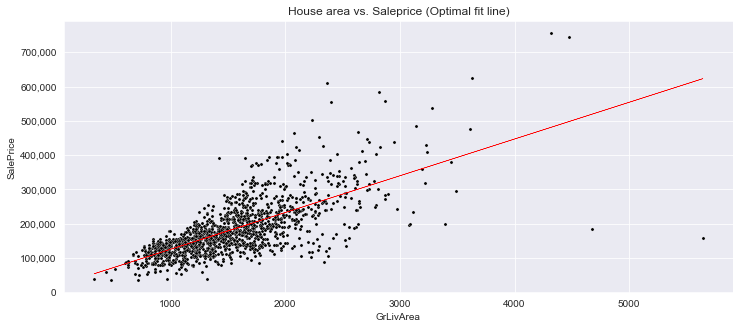

In [70]:
plt.figure(figsize=(12,5))
plt.title('House area vs. Saleprice (Optimal fit line)')
ax = sns.scatterplot(x, y, color='k', s=10)
plt.plot(x, NE_betas[0] + NE_betas[1]*x, color='r', linewidth=0.5)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

#### Singular Value Decomposition (SVD)

The main idea behind SVD is that we can decompose a matrix A, of any shape, into the product of 3 other matrices: $A = U\Sigma V^T$, where $U$ and $V$ are orthogonal matrices ($AA^T = A^TA = I$) and the matrix $\Sigma$ is diagonal and it stores non-negative singular values ordered by relevance.

Again, we want to solve for $Y=X\theta$.<br>

Let's start by decomposing $X$ to $U\Sigma V^T \rightarrow Y=U\Sigma V^T\theta \rightarrow (U\Sigma V^T)^{-1}Y=(U\Sigma V^T)^{-1}U\Sigma V^T\theta =V\Sigma^{-1}U^TU\Sigma V^T\theta = \theta \rightarrow (U\Sigma V^T)^{-1}Y = \theta$ <br>

Where $A^{\dagger}$ is defined as $(U\Sigma V^T)^{-1}$. Therefore, $\theta = A^{\dagger}Y$

In [55]:
X = np.c_[np.ones(x.shape[0]), x] #Add a column of 1s for the intercept

# Compute U, S and V
U,S,V = np.linalg.svd(X, full_matrices=False)
SVD_betas = V @ np.linalg.inv(np.diag(S)) @ U.T @ y

In [56]:
SVD_betas

array([18569.02585649,   107.13035897])

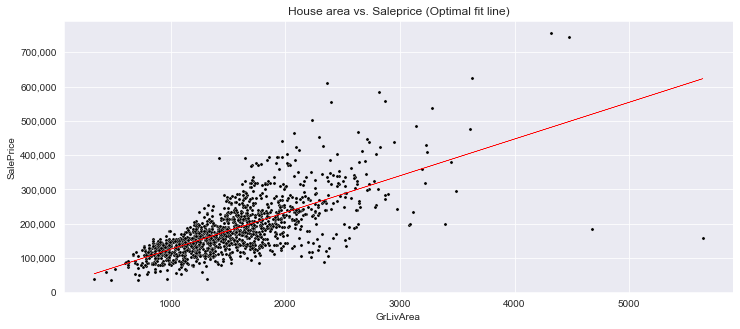

In [71]:
plt.figure(figsize=(12,5))
plt.title('House area vs. Saleprice (Optimal fit line)')
ax = sns.scatterplot(x, y, color='k', s=10)
plt.plot(x, SVD_betas[0] + SVD_betas[1]*x, color='r', linewidth=0.5)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

#### Compare solutions

In [191]:
betas = [GD_betas, NE_betas, SVD_betas]

X = np.c_[np.ones(x.shape[0]), x] #Add a column of 1s for the intercept

my_dict = {}
for beta_pair, name in zip(betas, ['Gradient Descent', 'Normal Equation', 'SVD']):
    prediction = np.dot(X, beta_pair)
    error = prediction - y
    cost = 1/(2*n) * np.dot(error.T, error)
    my_dict[name] = cost

pd.DataFrame.from_dict(my_dict, orient='index', columns=['Cost'])

,Cost
Gradient Descent,1.575477e+09
Normal Equation,1.569922e+09
SVD,1.569922e+09


* Gradient Descent has the highest cost as it is an iterative process and therefore not as accurate as the other methods.<br>
* The Normal Equation method was as had the same accuracy as the SVD method but it requires taking the inverse of a matrix, which can get very computationally expensive. 
* The SVD method is the most popular one as it can reach a solution as accurate as the Normal Equation's solution and it is far less computationally expensive.

#### R-squared

R squared is a statistical measure between 0 and 1 which calculates how similar a regression line is the regression line to the data.

$R^2= \frac{\text{Explained variance of the model}}{\text{Total variance of the target variable}}$  

If we theoretically only had Y data (and no X), the best predictive model we would be able to make would be to guess the average of Y every time.

In [ ]:
betas = GD_betas.copy()
Y_variance = np.sum((y - y.mean())**2)

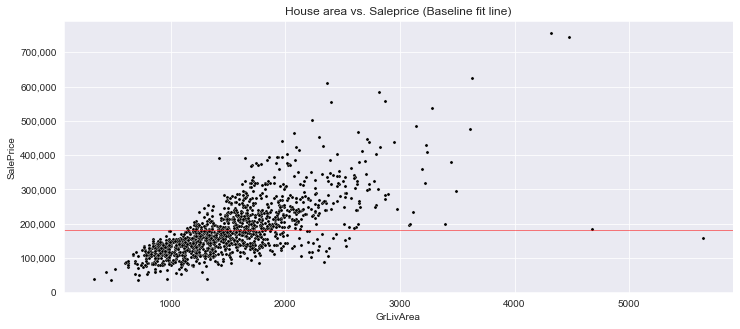

Total variance of the target variable: 9.207911e+12


In [63]:
plt.figure(figsize=(12,5))
plt.title('House area vs. Saleprice (Baseline fit line)')
ax = sns.scatterplot(x, y, color='k', s=10)
plt.axhline(y.mean(), color='r', linewidth=0.5)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

print('Total variance of the target variable: {}'.format("{:e}".format(Y_variance)))

In [65]:
y_pred = betas[0] + betas[1]*x
model_variance = np.sum((y - y_pred)**2)

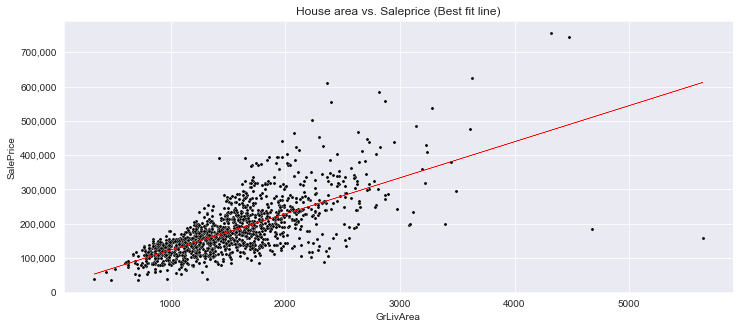

Total variance of the regression model: 4.600392e+12


In [66]:
plt.figure(figsize=(12,5))
plt.title('House area vs. Saleprice (Best fit line)')

ax = sns.scatterplot(x, y, color='k', s=10)
plt.plot(x, y_pred, color='r', linewidth=0.5)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()


print('Total variance of the regression model: {}'.format("{:e}".format(model_variance)))

Logically the variance is much smaller in our regression model, because we took into account the information gained through the linear relationship between our feature and the target variable instead of just using the target's mean.

If we want to quantify how much variance was explained by out model we need to take the difference between the total variance and the variance of our regression model.

In [207]:
explained_variance = Y_variance - model_variance
print('The total explained variance is: {}'.format("{:e}".format(explained_variance)))

The total explained variance is: 4.607519e+12


Now, let's calculate R-squared 

In [210]:
R = explained_variance / Y_variance

print('The R-squared for this model is: {}%'.format(round(R*100,2)))

The R-squared for this model is: 50.04%


Our model explaines 50.04% of the target variable's variance!

In [211]:
# Sanity check
r2_score(y, y_pred)

0.5003869938547452